# Controlled EEG-like Signals: AR processes, Filtering, and Spurious Phase Synchrony

Last updated: 11/11/2025

To model realistic EEG behavior (broad amplitude, controlled setting), generate two autoregressive (AR) processes that are: **completely independent**, and **exhibit irregular dynamics.**

0) Imports, config, and helpers

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg


def bandpass(y, fs, f_lo, f_hi, order=4):
    """
    Simple zero-phase Butterworth band-pass filter.
    Keeps only frequencies between f_lo and f_hi (Hz).
    """
    sos = sg.butter(order, [f_lo, f_hi], btype='bandpass', fs=fs, output='sos')
    return sg.sosfiltfilt(sos, y)


# Sampling settings (consistent everywhere)
fs = 200            # Hz
T  = 60             # seconds (longer = more stable estimates)
n  = T * fs         # samples
t  = np.arange(n) / fs

1) Two independent, irregular AR(2) processes (broadband)

In [ ]:
def plv_from_signals(a, b):
    pha = np.unwrap(np.angle(sg.hilbert(a)))
    phb = np.unwrap(np.angle(sg.hilbert(b)))
    z = np.exp(1j * (pha - phb))
    return np.abs(np.mean(z))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def generate_ar(phi, n, c=0, sigma=1, seed=None):

    rng = np.random.default_rng(seed)
    p = len(phi)
    x = np.zeros(n)
    eps = rng.normal(0, sigma, n)  # white noise

    # initialize with random values
    x[:p] = rng.normal(0, sigma, p)

    for t in range(p, n):
        x[t] = c + np.dot(phi, x[t - np.arange(1, p+1)]) + eps[t]

    # zero-mean, unit-variance for stability
    x -= x.mean()
    x /= x.std()

    return x

x1 = generate_ar([0.7, -0.3], 1000, seed=1)
x2 = generate_ar([0.5, -0.6], 1000, seed=2)

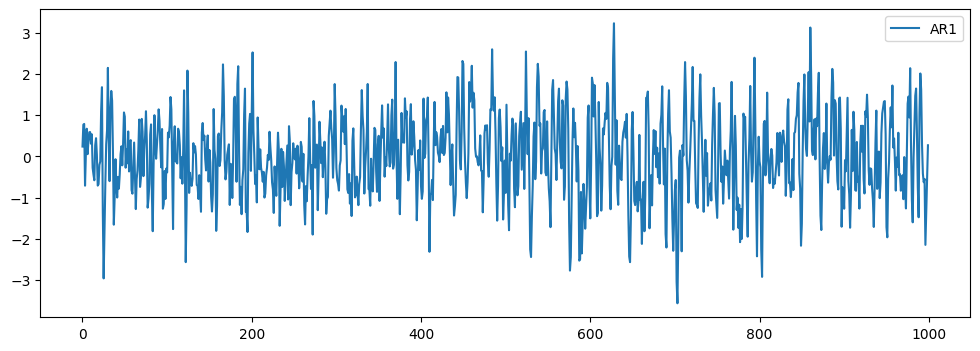

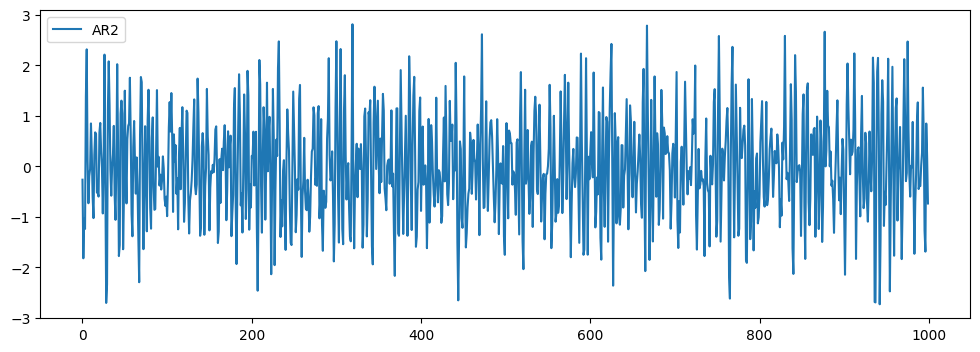

MPC AR:     0.0315


In [ ]:
plt.figure(figsize=(12,4))
plt.plot(x1, label='AR1')
plt.legend()
plt.show()


plt.figure(figsize=(12,4))
plt.plot(x2, label='AR2')
plt.legend()
plt.show()


mpc_nonoverlap = plv_from_signals(x1, x2)

print(f"MPC AR:     {mpc_nonoverlap:.4f}")

2) Low-pass / High-pass demos


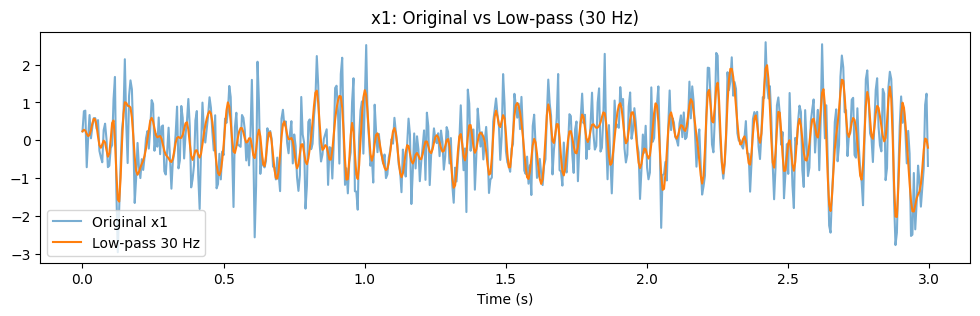

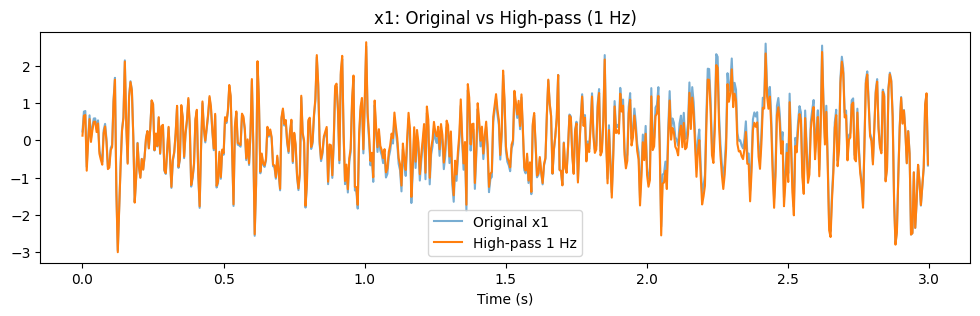

In [ ]:
# Low-pass at 30 Hz (example)
sos_lp = sg.butter(N=4, Wn=30, btype='lowpass', fs=fs, output='sos')
low_pass_x1 = sg.sosfiltfilt(sos_lp, x1)
low_pass_x2 = sg.sosfiltfilt(sos_lp, x2)

plt.figure(figsize=(12,3))
plt.plot(t[:3*fs], x1[:3*fs], alpha=0.6, label='Original x1')
plt.plot(t[:3*fs], low_pass_x1[:3*fs], label='Low-pass 30 Hz')
plt.title('x1: Original vs Low-pass (30 Hz)'); plt.xlabel('Time (s)'); plt.legend(); plt.show()

# High-pass at 1 Hz (example)
sos_hp = sg.butter(N=4, Wn=1, btype='highpass', fs=fs, output='sos')
high_pass_x1 = sg.sosfiltfilt(sos_hp, x1)
high_pass_x2 = sg.sosfiltfilt(sos_hp, x2)

plt.figure(figsize=(12,3))
plt.plot(t[:3*fs], x1[:3*fs], alpha=0.6, label='Original x1')
plt.plot(t[:3*fs], high_pass_x1[:3*fs], label='High-pass 1 Hz')
plt.title('x1: Original vs High-pass (1 Hz)'); plt.xlabel('Time (s)'); plt.legend(); plt.show()

3) Band-pass to make each process narrow-band (the key step)

We’ll use overlapping bands 6–8 Hz (for x1) and 7–9 Hz (for x2). The original AR(2) process has energy across many frequencies (broad amplitude spectrum), so its waveform looks random and irregular.
When you apply a band-pass, you remove most frequencies and leave mainly a small, coherent group — the waveform starts to “wiggle” at a more regular pace.
That’s why spectral entropy decreases: the signal’s power spectrum becomes concentrated.

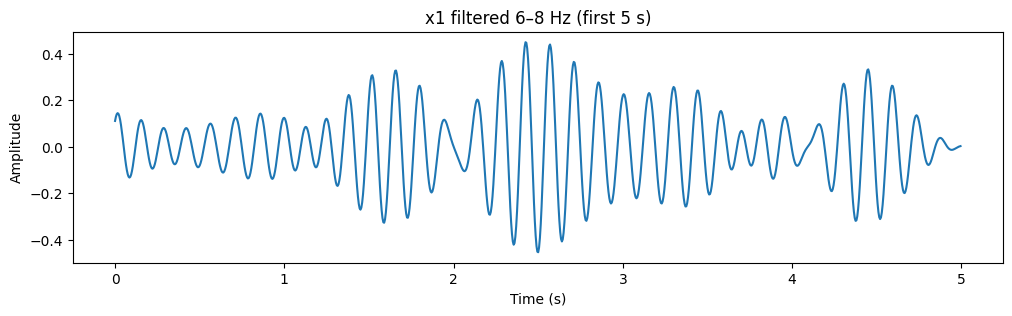

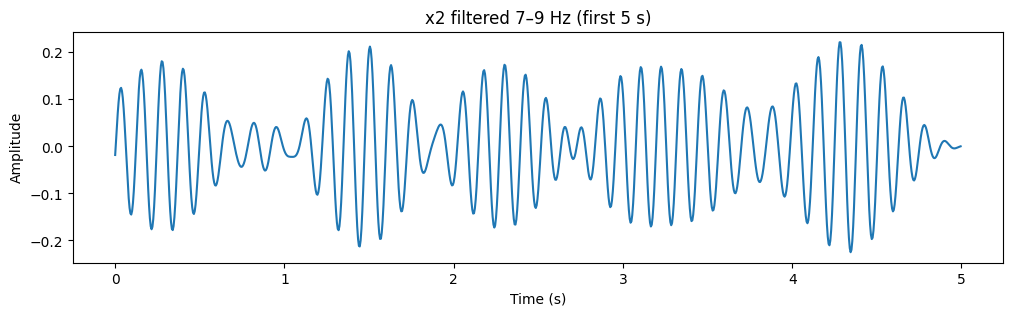

In [ ]:
# Build the two band-pass filters (zero-phase)
sos_bp_68 = sg.butter(N=4, Wn=[6, 8], btype='bandpass', fs=fs, output='sos')
sos_bp_79 = sg.butter(N=4, Wn=[7, 9], btype='bandpass', fs=fs, output='sos')

# Apply them
x1_68 = sg.sosfiltfilt(sos_bp_68, x1)
x2_79 = sg.sosfiltfilt(sos_bp_79, x2)

# Quick look at the first 5 seconds
plt.figure(figsize=(12,3))
plt.plot(t[:5*fs], x1_68[:5*fs]); plt.title('x1 filtered 6–8 Hz (first 5 s)')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.show()

plt.figure(figsize=(12,3))
plt.plot(t[:5*fs], x2_79[:5*fs]); plt.title('x2 filtered 7–9 Hz (first 5 s)')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.show()


**Expect the irregularity to decrease as the signals become more oscillatory!**

5) Mean Phase Coherence (PLV) between filtered signals

Then, compute mean phase coherence between the two signals:

Hypothesis:
- Even though the AR processes are independent, filtering them in slightly different bands (e.g. 6–8 Hz vs 7–9 Hz) might artificially increase the apparent phase coupling.
- This would show that filtering alone can create spurious phase synchrony between independent signals


PLV = Phase Locking Value
It’s also called Mean Phase Coherence (MPC) in some papers both mean the same thing... ask to confirm!

What it measures

PLV quantifies how consistent the phase difference between two signals is over time.

Imagine you compute the instantaneous phase of two narrow-band signals, using the Hilbert transform. Then you look at their phase difference.
- If that difference stays nearly constant (the two waveforms rise and fall together), their phases are locked → high PLV.
- If the difference wanders randomly, the signals are independent → low PLV.


In [ ]:
# Overlapping bands: 6–8 Hz (x1) vs 7–9 Hz (x2)
plv_overlap = plv_from_signals(x1_68, x2_79)

# Non-overlap control: for comparison (e.g., 2–4 Hz vs 10–12 Hz)
sos_bp_24 = sg.butter(N=4, Wn=[2, 4],  btype='bandpass', fs=fs, output='sos')
sos_bp_1012 = sg.butter(N=4, Wn=[10, 12], btype='bandpass', fs=fs, output='sos')
x1_24  = sg.sosfiltfilt(sos_bp_24, x1)
x2_1012 = sg.sosfiltfilt(sos_bp_1012, x2)
plv_nonoverlap = plv_from_signals(x1_24, x2_1012)

print(f"MPC (x1 6–8 Hz vs x2 7–9 Hz):     {plv_overlap:.4f}")
print(f"MPC (x1 2–4 Hz vs x2 10–12):  {plv_nonoverlap:.4f}")

MPC (x1 6–8 Hz vs x2 7–9 Hz):     0.1857
MPC (x1 2–4 Hz vs x2 10–12):  0.0205


/tmp/ipython-input-1824975267.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best')
/tmp/ipython-input-1824975267.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best')


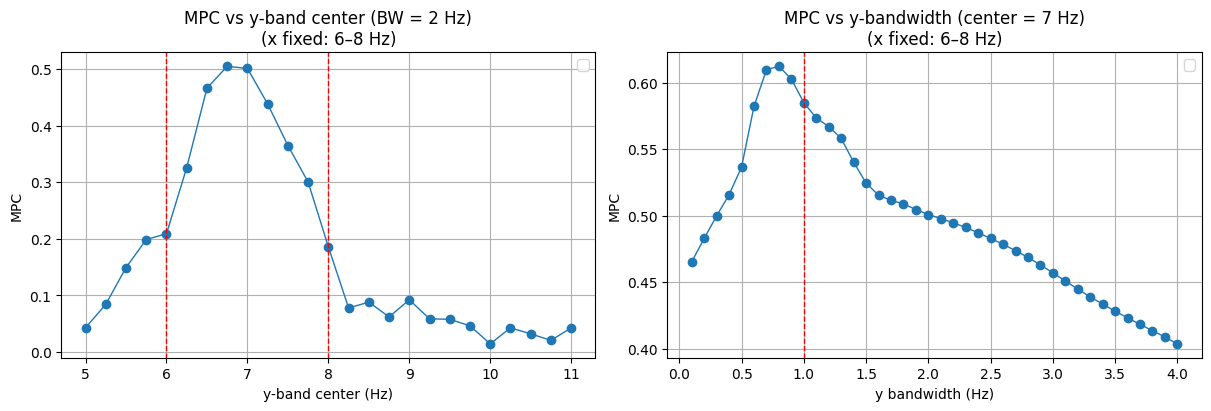

Max MPC vs center: 0.5045 at y center = 6.75 Hz
Max MPC vs bandwidth: 0.6123 at y bandwidth = 0.80 Hz


In [ ]:
# --- Sweep PLV with subplots  ---

# Fixed band for x1
x_band = (6, 8)

# 1) Sweep y-band center with fixed bandwidth
centers = np.arange(5.0, 11.01, 0.25)   # Hz
bw_fixed = 2.0                           # Hz (so bands like [c-1, c+1])
plv_vs_center = []

# Pre-filter x1 once (fixed band)
x1_bp = bandpass(x1, fs, x_band[0], x_band[1])

for c in centers:
    y_band = (c - bw_fixed/2, c + bw_fixed/2)
    # keep bands inside (0, Nyquist)
    if y_band[0] <= 0 or y_band[1] >= fs/2:
        plv_vs_center.append(np.nan)
        continue
    y2_bp = bandpass(x2, fs, y_band[0], y_band[1])
    plv_vs_center.append(plv_from_signals(x1_bp, y2_bp))

plv_vs_center = np.array(plv_vs_center)

# Compute which centers produce overlap with x_band
# Overlap if (y_lo < x_hi) and (y_hi > x_lo)
y_los = centers - bw_fixed/2
y_his = centers + bw_fixed/2
overlap_mask = (y_los < x_band[1]) & (y_his > x_band[0])

# 2) Sweep y-bandwidth with fixed center
center_fixed = 7.0                       # Hz
bws = np.arange(0.1, 4.01, 0.1)         # total bandwidths
plv_vs_bw = []

for BW in bws:
    y_band = (center_fixed - BW/2, center_fixed + BW/2)
    if y_band[0] <= 0 or y_band[1] >= fs/2:
        plv_vs_bw.append(np.nan)
        continue
    y2_bp = bandpass(x2, fs, y_band[0], y_band[1])
    plv_vs_bw.append(plv_from_signals(x1_bp, y2_bp))

plv_vs_bw = np.array(plv_vs_bw)

# --- Plot: two subplots side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

# Left: PLV vs center
ax = axes[0]
ax.plot(centers, plv_vs_center, marker='o', linewidth=1)
ax.set_title('MPC vs y-band center (BW = 2 Hz)\n(x fixed: 6–8 Hz)')
ax.set_xlabel('y-band center (Hz)')
ax.set_ylabel('MPC')
ax.grid(True)
ax.axvline(x=6, linestyle='--', linewidth=1, color='red')
ax.axvline(x=8, linestyle='--', linewidth=1, color='red')
if 'added_label' in locals():
    ax.legend(loc='best')

# Right: PLV vs bandwidth (center fixed)
ax = axes[1]
ax.plot(bws, plv_vs_bw, marker='o', linewidth=1)
# Shade bandwidths that create overlap with 6–8 Hz
# Overlap if (y_lo < 8) and (y_hi > 6) → with y_lo = 8 - BW/2, y_hi = 8 + BW/2
# That happens for BW > 0 (always), but we can highlight where the band fully covers 6–8:
# fully covers 6–8 if (8 - BW/2 <= 6) and (8 + BW/2 >= 8) → BW >= 4
full_cover_mask = bws >= 4.0

ax.set_title('MPC vs y-bandwidth (center = 7 Hz)\n(x fixed: 6–8 Hz)')
ax.set_xlabel('y bandwidth (Hz)')
ax.set_ylabel('MPC')
ax.grid(True)
ax.axvline(x=1, linestyle='--', linewidth=1, color='red')
if np.any(full_cover_mask):
    ax.legend(loc='best')

plt.show()

# Print a couple of handy summaries
best_center_idx = np.nanargmax(plv_vs_center)
print(f"Max MPC vs center: {plv_vs_center[best_center_idx]:.4f} at y center = {centers[best_center_idx]:.2f} Hz")

best_bw_idx = np.nanargmax(plv_vs_bw)
print(f"Max MPC vs bandwidth: {plv_vs_bw[best_bw_idx]:.4f} at y bandwidth = {bws[best_bw_idx]:.2f} Hz")


**LEFT PLOT**
x2 was filtered in a 2 Hz-wide band whose center was slid from 5 Hz → 11 Hz (so bands like 5–7, 5.25–7.25, …, 10–12 Hz).

Interpretation:
- PLV stays low (~0–0.1) when the bands don’t overlap → no shared frequency → no spurious synchrony.
- As soon as the y band moves into the overlap region (≈6–8 Hz), PLV rises sharply, peaking around 6.75 Hz (PLV ≈ 0.5).
- Once y moves past the overlap (≥ 9 Hz), PLV falls again.

**RIGHT PLOT** x2 centered at 8 Hz, but with different bandwidths (from 0.5 Hz to 4 Hz). So y’s band expands symmetrically: 7.75–8.25 Hz, 7–9 Hz, …, 6–10 Hz, etc.

Interpretation:

- Very narrow bands → low PLV: almost no shared content.
- As bandwidth increases and starts overlapping 6–8 Hz → PLV rises gradually.
- PLV peaks (~0.35) when y’s band fully includes 6–8 Hz (≈ 4 Hz wide).

Q's --> I don't understand the sudden peak (second point)

**CONCLUSION**

Even though the AR processes are independent, narrow-band filtering in overlapping frequency ranges can make them look phase-locked.
That’s why in EEG or other oscillatory analyses we must:

- Always check for band overlap when comparing channels or regions.

- Use non-overlapping filters or surrogate tests to confirm real coupling.

- Interpret high PLV cautiously. It might be a filter artifact, not true neural synchrony.
